In [1]:
## Importing the required python libraries 
import os, sys
import warnings
import timeit
import numpy as np
import pandas as pd 
import pkg_resources
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import defaultdict


In [2]:
## Importing pergene files 

pergene_files=[]
#data_dir= "../satay/data_files/data_unmerged/"
#data_dir="../transposonmapper/data_files/files4test/"
data_dir="../postprocessed-data/"
#data_dir="../transposonmapper/data_files/"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith("pergene_insertions.xlsx"):
            pergene_files.append(os.path.join(root, file))

list_data=[]
for i in pergene_files:
    list_data.append(pd.read_excel(i,engine='openpyxl',index_col="Unnamed: 0"))

keys=[]
for i in np.arange(0,len(pergene_files)):
    keys.append(pergene_files[i].split("/")[-1].split("_")[0]+"_"+pergene_files[i].split("/")[-1].split("_")[1])

list_data_pd=pd.concat(list_data,axis=0,keys=keys)

In [3]:
## Importing postproccesed data from pipeline

data_post=[]

for i in keys:
    data_post.append(pd.read_excel(data_dir+i+".xlsx",index_col="Unnamed: 0",engine='openpyxl'))
    
list_data_post=pd.concat(data_post,axis=0,keys=keys)
list_data_post.drop(columns=["Feature_alias","Feature_name"],inplace=True)
list_data_post.fillna(1,inplace=True)


In [4]:
list_data_post.head(2)
# list_data_pd.head()

Standard_name Feature_type  Essentiality Chromosome  Position  \
dbem3_b 0     noncoding            1           1.0          I    [0, 1]   
        1        TEL01L     Telomere           1.0          I  [2, 335]   

           Nbasepairs  Ninsertions  Ninsertions_truncatedgene  Nreads  \
dbem3_b 0           2            0                          0       0   
        1         334           38                         38    2356   

                                                 Nreads_list  \
dbem3_b 0                                               [0.]   
        1  [  0.   0.   0.   0.   0.   0.   0.   0.   0. ...   

           Nreads_truncatedgene  Nreadsperinsrt  Nreadsperinsrt_truncatedgene  
dbem3_b 0                     0        0.000000                           0.0  
        1                  2356       63.675676                          62.0

In [4]:
## Importing gene protein length , and protein domains coordinates of every gene 

protein_length=pd.read_csv('../data/Gene_Protein_length_yeastmine.tsv',sep="\t")
protein_length.index=protein_length.loc[:,"Gene Name"]
protein_length.drop(columns="Gene Name",inplace=True)

domains_coordinates=pd.read_csv('../data/Domains_all_genes_protein_coordinates_yeastmine.tsv',sep="\t")

domains_coordinates.dropna(inplace=True)
gene_with_introns=pd.read_csv('../data/Gene_Introns.tsv',sep="\t")



In [5]:
## Combine protein length and protein domains coordinates
domains_coordinates.loc[:,"Protein Length"]=np.nan
for gene_name in protein_length.index: 
    tmp=np.where(domains_coordinates.loc[:,"Gene Name"]==gene_name)[0]
    if tmp.size!=0: 
        for i in np.arange(0,len(tmp)):
            domains_coordinates.loc[tmp[i], "Protein Length"]=protein_length.loc[gene_name, "Protein Length"]

domains_coordinates.dropna(inplace=True) # to drop the proteins that do not have protein domains annotated
domains_coordinates.index=domains_coordinates.loc[:,"Gene Name"]
domains_coordinates.drop(columns="Gene Name",inplace=True)

In [7]:
domains_coordinates.head(2)

,Protein Domain,Protein domain description,Protein start location,Protein End location,Method,Domain ID,Protein Length
Gene Name,,,,,,,
AAC1,PF00153,Mitochondrial carrier protein; Mitochondrial s...,10,106,Pfam,2106639,309.0
AAC1,PF00153,Mitochondrial carrier protein; Mitochondrial s...,116,210,Pfam,2106640,309.0


In [13]:
## Add for every gene name from the pergene files , a column with an array of the protein domains
# founded in the domains coordinates file, as well as the length of the protein,and the
# end location and start location of every protein domain
list_data_domains_data=list_data_pd.copy()
df=list_data_domains_data.loc["wt_merged"]
df.set_index("Gene name",inplace=True)

    


In [14]:

## make a dictionary with protein domains locations per gene , the solution of an array and attaching it
# a dataframe do not work, so I will use a dictionary

domain_locations=defaultdict(dict)

for j in df.index:
    if j in domains_coordinates.index:
        if len([domains_coordinates.loc[j,"Protein Domain"]])>1:
            for i in np.arange(0,len(domains_coordinates.loc[j,"Protein Domain"].tolist())):
            
                domain_locations[j][i]=(np.array([domains_coordinates.loc[j,"Protein start location"][i],domains_coordinates.loc[j,
        "Protein End location"][i]]))
        else:
            domain_locations[j]=(np.array([domains_coordinates.loc[j,"Protein start location"],domains_coordinates.loc[j,
    "Protein End location"]]))
    else:
        domain_locations[j]=np.nan


domains_names=defaultdict(dict)


for j in df.index:
    if j in domains_coordinates.index:
        if type(domains_coordinates.loc[j,"Protein Domain"])!=str:
            if len(domains_coordinates.loc[j,"Protein Domain"].tolist())>1:
                for i in np.arange(0,len(domains_coordinates.loc[j,"Protein Domain"].tolist())):
                    domains_names[j][i]=np.array(domains_coordinates.loc[j,"Protein Domain"][i])
            else:
                domains_names[j]=np.array(domains_coordinates.loc[j,"Protein Domain"])
        else:
            domains_names[j]=np.array(domains_coordinates.loc[j,"Protein Domain"])
    else:
        domains_names[j]=np.nan
        


for i in df.index:
    if i in domains_coordinates.index:
        df.loc[i,"protein length"]=np.unique(domains_coordinates.loc[i,"Protein Length"]).tolist()

    else:
        df.loc[i,"protein length"]=np.nan



/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pan

In [15]:
domains_names_df=pd.DataFrame.from_dict(domains_names,orient="index")
domains_names_df.columns=["protein domain"]

domain_locations_df=pd.DataFrame.from_dict(domain_locations,orient="index")
domain_locations_df.columns=["domain locations"]


In [16]:
df_merged=pd.merge(df,domain_locations_df,left_index=True,right_index=True)

df_merged_II=pd.merge(df_merged,domains_names_df,left_index=True,right_index=True)

df_merged_II.loc["AAC1"]

Chromosome                                                                   XIII
Start location                                                             387315
End location                                                               388244
Insertion locations             [387357, 387361, 387373, 387402, 387480, 38751...
Reads per insertion location    [6, 41, 48, 6, 104, 262, 19, 95, 155, 84, 9, 7...
Reads                                                                        2388
Insertions                                                                     37
protein length                                                              309.0
domain locations                                [[10, 116, 217], [106, 210, 304]]
protein domain                               {0: PF00153, 1: PF00153, 2: PF00153}
Name: AAC1, dtype: object

In [14]:
## Example on how to translate protein domains coordinates to genomic coordinates
from from_excel_to_list import from_excel_to_list
gene="AAC1"

genomic_length=df_merged_II.loc[gene,"End location"]-df_merged_II.loc[gene,"Start location"]
protein_length=df_merged_II.loc[gene,"protein length"]

domain_1_protein=[df_merged_II.loc[gene,"domain locations"][1][0],df_merged_II.loc[gene,"domain locations"][0][0]]

domain_1_protein_rel=domain_1_protein/protein_length

domain_1_genomic_rel=np.round(domain_1_protein_rel*genomic_length)

domain_1_genomic=[domain_1_genomic_rel[1]+df_merged_II.loc[gene,"Start location"],
domain_1_genomic_rel[0]+df_merged_II.loc[gene,"Start location"]]

insertions_vector=from_excel_to_list(df_merged_II.loc[gene,"Insertion locations"])
reads_vector=from_excel_to_list(df_merged_II.loc[gene,"Reads per insertion location"])

pos_domain_1=[]

for i in np.arange(0,len(insertions_vector)):
    if domain_1_genomic[0]<=insertions_vector[i] and insertions_vector[i]<=domain_1_genomic[1]:
        
        pos_domain_1.append(reads_vector[i])
       

reads_domain_1=np.sum(pos_domain_1)

In [15]:
domain_1_genomic[0],domain_1_genomic[1],reads_domain_1

(387345.0, 387634.0, 293.0)

In [23]:
type(df_merged_II.loc["YAL069W","domain locations"])

float

In [10]:
## Function to get the reads per domain per gene 

def get_reads_per_domain(data,gene):

    from from_excel_to_list import from_excel_to_list

    genomic_length=data.loc[gene,"End location"]-data.loc[gene,"Start location"]
    protein_length=data.loc[gene,"protein length"]

    insertions_vector=from_excel_to_list(df_merged_II.loc[gene,"Insertion locations"])
    reads_vector=from_excel_to_list(df_merged_II.loc[gene,"Reads per insertion location"])

    
    domain_genomic=[]
    tmp=df_merged_II.loc[gene,"domain locations"]
    
    if type(tmp)!=float : 

        if type(tmp.tolist()[0])!=int:
            
            for i in np.arange(0,int(len(np.concatenate(tmp).tolist())/2)):
            
                domain_protein=[data.loc[gene,"domain locations"][1][i],data.loc[gene,"domain locations"][0][i]]

                domain_protein_rel=domain_protein/protein_length

                domain_genomic_rel=np.round(domain_protein_rel*genomic_length)

                domain_genomic.append([domain_genomic_rel[1]+df_merged_II.loc[gene,"Start location"],
        domain_genomic_rel[0]+df_merged_II.loc[gene,"Start location"]])

        else:

                domain_protein=[data.loc[gene,"domain locations"][1],data.loc[gene,"domain locations"][0]]

                domain_protein_rel=domain_protein/protein_length

                domain_genomic_rel=np.round(domain_protein_rel*genomic_length)

                domain_genomic.append([domain_genomic_rel[1]+df_merged_II.loc[gene,"Start location"],
        domain_genomic_rel[0]+df_merged_II.loc[gene,"Start location"]])


    

    
    reads_domain=[]
    for j in np.arange(0,len(domain_genomic)):
        pos_domain=[]
        if type(insertions_vector)!=int:
            for i in np.arange(0,len(insertions_vector)):     

                if domain_genomic[j][0]<=insertions_vector[i] and insertions_vector[i]<=domain_genomic[j][1]:
                    pos_domain.append(reads_vector[i])       

            reads_domain.append(np.sum(pos_domain))

    return reads_domain,domain_genomic

In [11]:
reads_per_domain=defaultdict(dict)
domain_genomics_coordinates=defaultdict(dict)
for gene in df_merged_II.index:
    reads_per_domain[gene],domain_genomics_coordinates[gene]=get_reads_per_domain(df_merged_II,gene)



In [12]:
reads_per_domain_df=pd.DataFrame.from_dict(reads_per_domain,orient="index")

domain_genomics_coordinates_df=pd.DataFrame.from_dict(domain_genomics_coordinates,orient="index")

#reads_per_domain_df.fillna(np.nan,inplace=True)

reads_per_domain_df.loc["BEM1"].dropna().tolist()

[187.0, 0.0, 0.0]

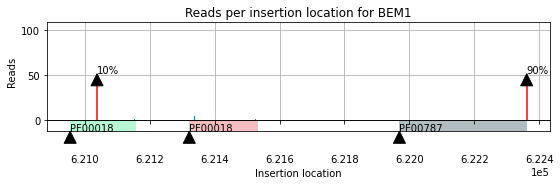

In [49]:
## Plot the reads per gene with the domain locations underneath 


 ## prototype for one gene
from from_excel_to_list import from_excel_to_list


gene="BEM1"

reads_vector=from_excel_to_list(df_merged_II.loc[gene,"Reads per insertion location"])

insertions_vector=from_excel_to_list(df_merged_II.loc[gene,"Insertion locations"])

start_location=df_merged_II.loc[gene,"Start location"]
end_location=df_merged_II.loc[gene,"End location"]
length=end_location-start_location

length_10_first=0.1*length
length_10_last=0.9*length

plt.figure(figsize=(9,2))
grid = plt.GridSpec(10, 1, wspace=0.0, hspace=0.01)

axc = plt.subplot(grid[9,0])

ax = plt.subplot(grid[0:9,0])
ax.set_xlabel("Insertion location")
ax.set_ylabel("Reads")

ax.set_title("Reads per insertion location for " + gene )
# plt.xlim(start_location,end_location)

ax.vlines(ymax=np.max(reads_vector)/2,ymin=0,x=start_location+length_10_first,color="red")
ax.vlines(ymax=np.max(reads_vector)/2,ymin=0,x=start_location+length_10_last,color="red")

ax.annotate("10%",xy=(start_location+length_10_first,np.max(reads_vector)/2),arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate("90%",xy=(start_location+length_10_last,np.max(reads_vector)/2),arrowprops=dict(facecolor='black', shrink=0.05))

noncoding_color = "#002538"
essential_color = "#10e372"
nonessential_color = "#d9252e"
codingdna_color = '#29a7e6'
textcolor = "#000000"

textsize = 10


axc.tick_params(labelsize=textsize)
axc.set_yticklabels([])
axc.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axc.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False)   # labels along the bottom edge are off

ax.grid(linestyle='-', alpha=1.0)
ax.tick_params(labelsize=textsize)

ax.tick_params(axis='x', which='major', pad=30)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.xaxis.get_offset_text().set_fontsize(textsize)
#ax.set_xlabel("Basepair position on chromosome "+chrom, fontsize=textsize, color=textcolor, labelpad=10)

ax.bar(from_excel_to_list( df_merged_II.loc[gene,"Insertion locations"]),
reads_vector)
facecolor=[essential_color,nonessential_color,noncoding_color,codingdna_color]


i=0
for width in domain_genomics_coordinates_df.loc[gene].dropna().tolist():
    axc.axvspan(width[0],width[1],facecolor=facecolor[i],alpha=0.3)
    axc.annotate(str(df_merged_II.loc[gene,"protein domain"][i]),xy=(width[0],0),arrowprops=dict(facecolor='black', shrink=0.05))
    i+=1
    
  

In [42]:
domain_genomics_coordinates_df.loc["BEM1"].dropna().tolist()
# reads_per_domain_df.loc[gene].dropna().tolist(),
str(df_merged_II.loc[gene,"protein domain"][0])



'PF00018'

In [29]:
list_data_post_new=list_data_post.loc[keys[0]]

list_data_post_new.index=list_data_post_new["Standard_name"]
list_data_post_new.drop(["Standard_name"],axis=1,inplace=True)

list_data_post_new.loc[gene,"Essentiality"].unique().tolist()

/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[0.0]

In [32]:
list_data_post_new=list_data_post.loc[keys[0]]

list_data_post_new.index=list_data_post_new["Standard_name"]
list_data_post_new.drop(["Standard_name"],axis=1,inplace=True)

for gene in df_merged_II.index:
    if gene in list_data_post_new.index:
        if type(list_data_post_new.loc[gene,"Essentiality"])!=np.float64:
            df_merged_II.loc[gene,"essentiality"]=list_data_post_new.loc[gene,"Essentiality"].unique().tolist()
        else:
            df_merged_II.loc[gene,"essentiality"]=list_data_post_new.loc[gene,"Essentiality"]

/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [35]:
df_merged_II

,Chromosome,Start location,End location,Insertion locations,Reads per insertion location,Reads,Insertions,protein length,domain locations,protein domain,essentiality
YAL069W,I,335,649,"[336, 340, 349, 372, 377, 382, 386, 386, 387, ...","[3, 327, 87, 1, 3, 12, 39, 1, 43, 6, 3, 45, 1,...",2353,55,NaN,NaN,NaN,0.0
YAL068W-A,I,538,792,"[559, 561, 564, 565, 569, 570, 570, 571, 573, ...","[6, 1, 2, 2, 147, 9, 154, 17, 177, 1, 132, 5, ...",694,25,NaN,NaN,NaN,NaN
PAU8,I,1807,2169,"[1810, 1819, 1826, 1831, 1833, 1838, 1846, 188...","[3, 30, 16, 2, 8, 1, 12, 50, 1, 3, 2, 1, 44, 2...",416,29,120.0,"[22, 114]",PF00660,0.0
YAL067W-A,I,2480,2707,"[2494, 2534, 2552, 2560, 2561, 2561, 2574, 257...","[20, 1, 7, 6, 8, 1, 4, 4, 2, 21, 2, 1, 3, 4, 4...",90,17,NaN,NaN,NaN,NaN
SEO1,I,7235,9016,"[7294, 7299, 7326, 7403, 7403, 7404, 7408, 744...","[38, 1, 1, 84, 1, 12, 32, 1, 3, 5, 1, 6, 52, 4...",1394,70,593.0,"[144, 503]",PF07690,0.0
...,...,...,...,...,...,...,...,...,...,...,...
ARR3,XVI,939922,941136,"[939931, 939933, 939934, 939943, 939945, 93996...","[74, 1, 2, 1, 1, 1, 27, 23, 19, 4, 3, 1, 1, 33...",1004,71,404.0,"[78, 275]",PF01758,0.0
YPR202W,XVI,943032,943896,"[943035, 943041, 943063, 943072, 943077, 94308...","[45, 1, 3, 8, 9, 1, 19, 9, 20, 27, 8, 12, 9, 1...",738,92,NaN,NaN,NaN,0.0
YPR203W,XVI,943880,944188,"[943883, 943895, 943907, 943912, 943917, 94393...","[12, 5, 25, 1, 1, 1, 1, 1, 36, 9, 1, 1, 8, 2, ...",721,62,NaN,NaN,NaN,0.0
YPR204W,XVI,944603,947701,"[944623, 944625, 944629, 944630, 944631, 94463...","[5, 2, 2, 7, 5, 60, 1, 9, 14, 2, 17, 9, 2, 11,...",4028,438,NaN,NaN,NaN,NaN


In [52]:
df.loc["AAC1","Protein domains locations"]=b[0][0]

In [41]:
np.concatenate(b,axis=0).tolist()

[10, 106, 116, 210, 217, 304]

In [ ]:
df.loc[tmp,"Gene name"]

'AAC1'